## Visualizations

### Importing Libraries

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from torchvision.transforms import Compose, Normalize, ToTensor
from medmnist import BreastMNIST
from torch.utils.data import DataLoader

# Import your model
import sys
sys.path.append('..')
from task import Net

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [29]:
# Optional: Install wandb if not already installed
# !pip install wandb -q

## 1. WandB Runs Comparison

**Note on Reproducibility**: This notebook can run in two modes:
- **WandB Mode**: Fetches live data from WandB (requires authentication and project access)
- **Offline Mode**: Uses exported CSV data (`wandb_runs_export.csv`) for reproducibility

The model evaluation section (Section 2) works independently and only requires the saved model file.

In [30]:
# Load WandB configuration from hidden file
def load_wandb_config():
    """Load WandB credentials from config file (optional for reproducibility)"""
    config = {}
    config_path = '../.wandb_config'
    try:
        with open(config_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    key, value = line.split('=', 1)
                    config[key] = value
        return config.get('WANDB_ENTITY'), config.get('WANDB_PROJECT')
    except FileNotFoundError:
        return None, None

entity, project_name = load_wandb_config()

# Configuration for offline mode
RUNS_DATA_FILE = '../wandb_runs_export.csv'
USE_WANDB = entity is not None and project_name is not None

if USE_WANDB:
    print(f"📡 WandB mode: Will fetch data from {entity}/{project_name}")
else:
    print(f"💾 Offline mode: Will load data from {RUNS_DATA_FILE}")
    print("   (To enable WandB mode, create .wandb_config file with your credentials)")

📡 WandB mode: Will fetch data from louisewiljander-ludwig-maximilianuniversity-of-munich/FedCAD


In [31]:
if USE_WANDB:
    # Fetch data from WandB (requires authentication)
    import wandb
    
    api = wandb.Api()
    
    try:
        print(f"Fetching runs from WandB...")
        runs = api.runs(f"{entity}/{project_name}")
        
        # Collect run data
        run_data = []
        for run in runs:
            run_data.append({
                'run_id': run.id,
                'name': run.name,
                'state': run.state,
                'num_rounds': run.config.get('num_rounds', None),
                'fraction_train': run.config.get('fraction_train', None),
                'lr': run.config.get('lr', None),
                'final_test_accuracy': run.summary.get('final_test_accuracy', None),
                'final_test_loss': run.summary.get('final_test_loss', None),
                'total_communication_MB': run.summary.get('total_communication_MB', None),
                'created_at': run.created_at,
            })
        
        # Create DataFrame
        df_runs = pd.DataFrame(run_data)
        df_runs = df_runs.sort_values('final_test_accuracy', ascending=False)
        
        # Save for offline use
        df_runs.to_csv(RUNS_DATA_FILE, index=False)
        print(f"✅ Fetched {len(df_runs)} runs and saved to {RUNS_DATA_FILE}")
        
    except Exception as e:
        print(f"❌ Error fetching from WandB: {e}")
        print(f"Falling back to offline data from {RUNS_DATA_FILE}")
        df_runs = pd.read_csv(RUNS_DATA_FILE)
        
else:
    # Load from exported CSV (for reproducibility without WandB access)
    try:
        df_runs = pd.read_csv(RUNS_DATA_FILE)
        print(f"✅ Loaded {len(df_runs)} runs from {RUNS_DATA_FILE}")
    except FileNotFoundError:
        print(f"❌ Error: {RUNS_DATA_FILE} not found!")
        print("Please run this notebook with WandB access first to generate the data file,")
        print("or obtain the wandb_runs_export.csv file from the project repository.")
        df_runs = pd.DataFrame()  # Empty dataframe

# Display summary
if not df_runs.empty:
    print(f"\nTotal runs: {len(df_runs)}")
    display(df_runs.head(10))
else:
    print("\n⚠️ No data available. Cannot proceed with WandB analysis.")

Fetching runs from WandB...
✅ Fetched 3 runs and saved to ../wandb_runs_export.csv

Total runs: 3


,run_id,name,state,num_rounds,fraction_train,lr,final_test_accuracy,final_test_loss,total_communication_MB,created_at
0,wp0k21zt,federated_server,finished,3.0,0.5,0.010,0.763636,0.491397,NaN,2025-11-19T15:35:39Z
1,rvz2b0s8,federated_server,finished,3.0,0.5,0.010,0.236364,0.699693,12.055893,2025-11-19T15:47:48Z
2,tw5xcg40,centralized,finished,NaN,NaN,0.001,NaN,NaN,NaN,2025-12-03T13:30:34Z


### Hyperparameter Comparison

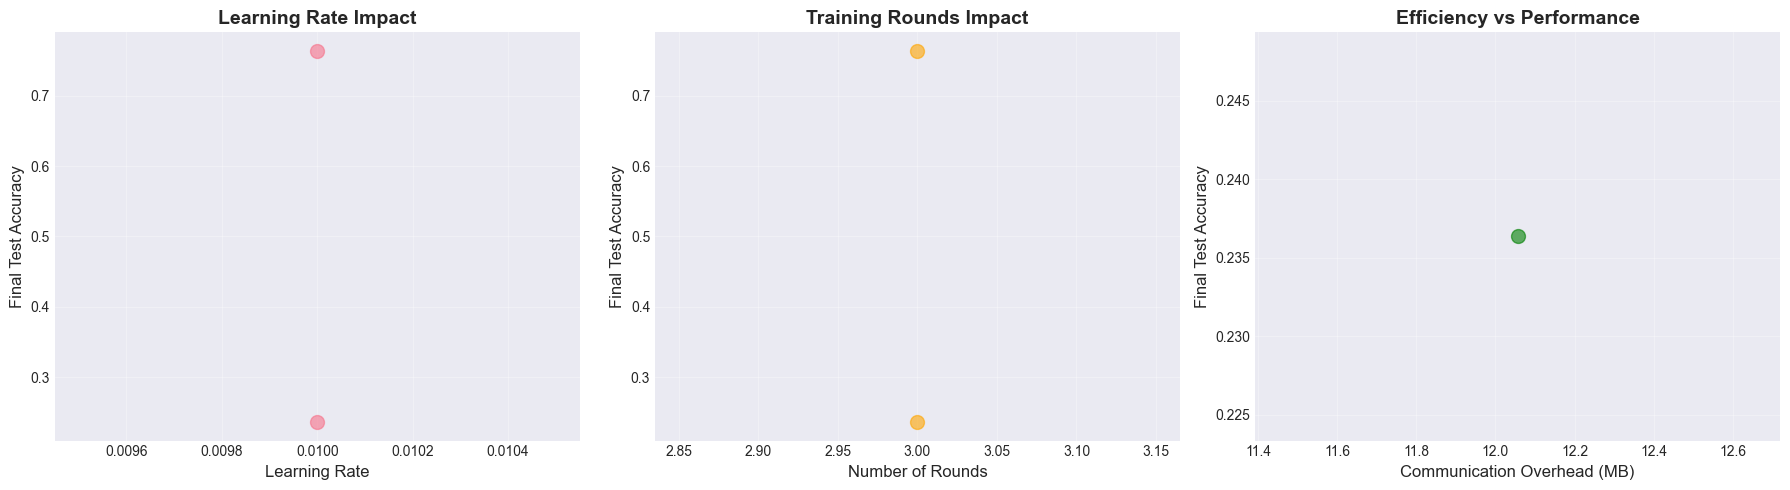

In [32]:
# Visualize hyperparameter impact
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Learning rate vs Accuracy
if 'lr' in df_runs.columns and df_runs['lr'].notna().any():
    axes[0].scatter(df_runs['lr'], df_runs['final_test_accuracy'], s=100, alpha=0.6)
    axes[0].set_xlabel('Learning Rate', fontsize=12)
    axes[0].set_ylabel('Final Test Accuracy', fontsize=12)
    axes[0].set_title('Learning Rate Impact', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

# Plot 2: Number of rounds vs Accuracy
if 'num_rounds' in df_runs.columns and df_runs['num_rounds'].notna().any():
    axes[1].scatter(df_runs['num_rounds'], df_runs['final_test_accuracy'], s=100, alpha=0.6, color='orange')
    axes[1].set_xlabel('Number of Rounds', fontsize=12)
    axes[1].set_ylabel('Final Test Accuracy', fontsize=12)
    axes[1].set_title('Training Rounds Impact', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

# Plot 3: Communication overhead vs Accuracy
if 'total_communication_MB' in df_runs.columns and df_runs['total_communication_MB'].notna().any():
    axes[2].scatter(df_runs['total_communication_MB'], df_runs['final_test_accuracy'], s=100, alpha=0.6, color='green')
    axes[2].set_xlabel('Communication Overhead (MB)', fontsize=12)
    axes[2].set_ylabel('Final Test Accuracy', fontsize=12)
    axes[2].set_title('Efficiency vs Performance', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Training Progress for Best Run

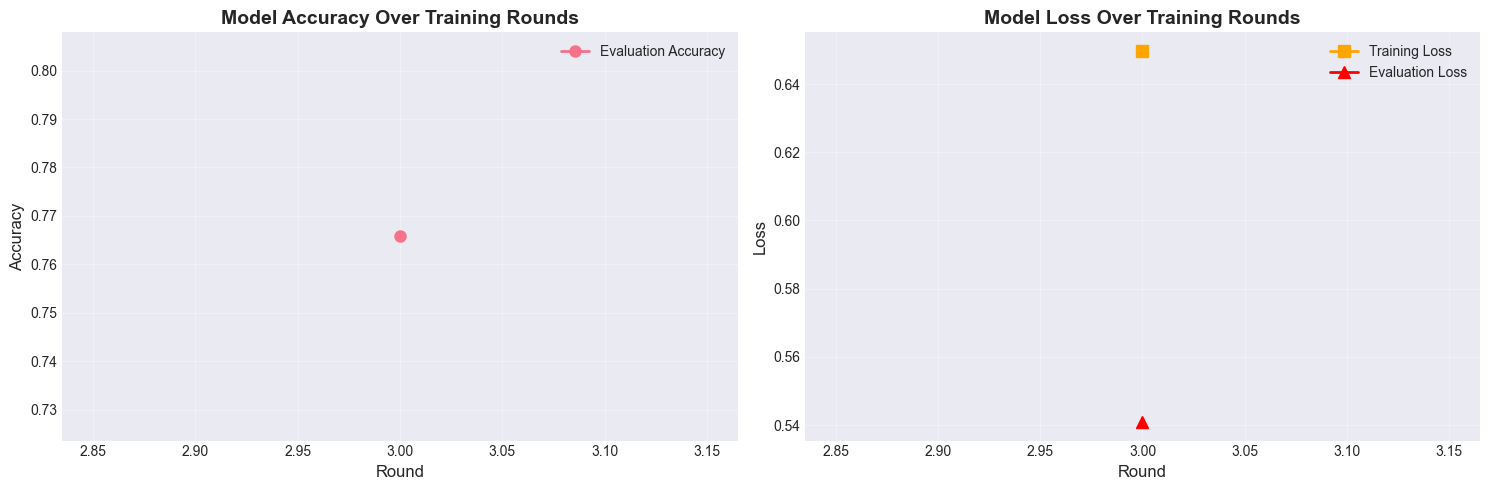

In [33]:
# Note: This cell requires WandB access and will be skipped in offline mode
if USE_WANDB and not df_runs.empty:
    try:
        import wandb
        api = wandb.Api()
        
        # Get the best run
        best_run_id = df_runs.iloc[0]['run_id']
        best_run = api.run(f"{entity}/{project_name}/{best_run_id}")
        
        # Fetch history (metrics over time)
        history = best_run.history()
        
        # Extract round-level metrics
        round_metrics = {}
        for col in history.columns:
            if col.startswith('round_') and '/eval_acc' in col:
                round_num = int(col.split('_')[1].split('/')[0])
                if round_num not in round_metrics:
                    round_metrics[round_num] = {}
                round_metrics[round_num]['eval_acc'] = history[col].iloc[-1]
            elif col.startswith('round_') and '/eval_loss' in col:
                round_num = int(col.split('_')[1].split('/')[0])
                if round_num not in round_metrics:
                    round_metrics[round_num] = {}
                round_metrics[round_num]['eval_loss'] = history[col].iloc[-1]
            elif col.startswith('round_') and '/train_loss' in col:
                round_num = int(col.split('_')[1].split('/')[0])
                if round_num not in round_metrics:
                    round_metrics[round_num] = {}
                round_metrics[round_num]['train_loss'] = history[col].iloc[-1]
        
        # Create training progress plots
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        if round_metrics:
            rounds = sorted(round_metrics.keys())
            eval_acc = [round_metrics[r].get('eval_acc', np.nan) for r in rounds]
            eval_loss = [round_metrics[r].get('eval_loss', np.nan) for r in rounds]
            train_loss = [round_metrics[r].get('train_loss', np.nan) for r in rounds]
            
            # Plot 1: Accuracy over rounds
            axes[0].plot(rounds, eval_acc, marker='o', linewidth=2, markersize=8, label='Evaluation Accuracy')
            axes[0].set_xlabel('Round', fontsize=12)
            axes[0].set_ylabel('Accuracy', fontsize=12)
            axes[0].set_title('Model Accuracy Over Training Rounds', fontsize=14, fontweight='bold')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Plot 2: Loss over rounds
            axes[1].plot(rounds, train_loss, marker='s', linewidth=2, markersize=8, label='Training Loss', color='orange')
            axes[1].plot(rounds, eval_loss, marker='^', linewidth=2, markersize=8, label='Evaluation Loss', color='red')
            axes[1].set_xlabel('Round', fontsize=12)
            axes[1].set_ylabel('Loss', fontsize=12)
            axes[1].set_title('Model Loss Over Training Rounds', fontsize=14, fontweight='bold')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Could not fetch detailed training history from WandB: {e}")
        print("Skipping training progress plots.")
else:
    print("⚠️ Skipping training progress plots (requires WandB access).")
    print("   This section shows round-by-round training metrics from WandB logs.")

## 3. Detailed Federated Model Evaluation

In [ ]:
# 5. Per-Class Performance Comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Calculate per-class metrics
from sklearn.metrics import classification_report

fed_report = classification_report(fed_labels, fed_preds, output_dict=True, 
                                   target_names=['Benign', 'Malignant'])
cent_report = classification_report(cent_labels, cent_preds, output_dict=True,
                                    target_names=['Benign', 'Malignant'])

# Prepare data for plotting
classes = ['Benign', 'Malignant']
metrics = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(classes))
width = 0.12

# Plot grouped bars
for i, metric in enumerate(metrics):
    metric_key = metric.lower().replace('-', '-')
    fed_values = [fed_report['Benign'][metric_key], fed_report['Malignant'][metric_key]]
    cent_values = [cent_report['Benign'][metric_key], cent_report['Malignant'][metric_key]]
    
    offset_fed = (i - 1) * width
    offset_cent = (i - 0.5) * width
    
    ax.bar(x + offset_fed, fed_values, width, 
           label=f'Fed. {metric}' if i == 0 else f'{metric}',
           alpha=0.7, edgecolor='black')
    ax.bar(x + offset_cent, cent_values, width,
           label=f'Cent. {metric}' if i == 0 else f'{metric}',
           alpha=0.7, edgecolor='black', hatch='//')

ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.set_title('Per-Class Performance: Federated vs Centralized', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\n" + "="*80)
print("DETAILED COMPARISON - CLASSIFICATION REPORTS")
print("="*80)
print("\n📊 FEDERATED MODEL:")
print(classification_report(fed_labels, fed_preds, target_names=['Benign', 'Malignant']))
print("\n📊 CENTRALIZED MODEL:")
print(classification_report(cent_labels, cent_preds, target_names=['Benign', 'Malignant']))
print("="*80)

In [ ]:
# 4. Side-by-side Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Federated confusion matrix
sns.heatmap(fed_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'],
            cbar_kws={'label': 'Count'})
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_title(f'Federated Model\n(Accuracy: {fed_accuracy:.2f}%)', 
                 fontsize=14, fontweight='bold')

# Centralized confusion matrix
sns.heatmap(cent_cm, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'],
            cbar_kws={'label': 'Count'})
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_title(f'Centralized Model\n(Accuracy: {cent_accuracy:.2f}%)', 
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 3. ROC Curves Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Federated ROC
fed_fpr, fed_tpr, _ = roc_curve(fed_labels, fed_probs[:, 1])
fed_auc = auc(fed_fpr, fed_tpr)

# Centralized ROC
cent_fpr, cent_tpr, _ = roc_curve(cent_labels, cent_probs[:, 1])
cent_auc = auc(cent_fpr, cent_tpr)

# Plot ROC curves
axes[0].plot(fed_fpr, fed_tpr, color='#3498db', lw=2, 
            label=f'Federated (AUC = {fed_auc:.3f})')
axes[0].plot(cent_fpr, cent_tpr, color='#e74c3c', lw=2, 
            label=f'Centralized (AUC = {cent_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(True, alpha=0.3)

# Precision-Recall curves
fed_precision_curve, fed_recall_curve, _ = precision_recall_curve(fed_labels, fed_probs[:, 1])
fed_pr_auc = auc(fed_recall_curve, fed_precision_curve)

cent_precision_curve, cent_recall_curve, _ = precision_recall_curve(cent_labels, cent_probs[:, 1])
cent_pr_auc = auc(cent_recall_curve, cent_precision_curve)

axes[1].plot(fed_recall_curve, fed_precision_curve, color='#3498db', lw=2,
            label=f'Federated (AUC = {fed_pr_auc:.3f})')
axes[1].plot(cent_recall_curve, cent_precision_curve, color='#e74c3c', lw=2,
            label=f'Centralized (AUC = {cent_pr_auc:.3f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 1. Accuracy Comparison Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
models = ['Federated\nLearning', 'Centralized\nLearning']
accuracies = [fed_accuracy, cent_accuracy]
colors = ['#3498db', '#e74c3c']

bars = axes[0].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([min(accuracies) - 5, 100])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Confusion Matrices Side by Side
fed_cm = confusion_matrix(fed_labels, fed_preds)
cent_cm = confusion_matrix(cent_labels, cent_preds)

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

fed_precision = precision_score(fed_labels, fed_preds, average='weighted')
fed_recall = recall_score(fed_labels, fed_preds, average='weighted')
fed_f1 = f1_score(fed_labels, fed_preds, average='weighted')

cent_precision = precision_score(cent_labels, cent_preds, average='weighted')
cent_recall = recall_score(cent_labels, cent_preds, average='weighted')
cent_f1 = f1_score(cent_labels, cent_preds, average='weighted')

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fed_metrics = [fed_accuracy, fed_precision*100, fed_recall*100, fed_f1*100]
cent_metrics = [cent_accuracy, cent_precision*100, cent_recall*100, cent_f1*100]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1].bar(x - width/2, fed_metrics, width, label='Federated', color='#3498db', alpha=0.7, edgecolor='black')
bars2 = axes[1].bar(x + width/2, cent_metrics, width, label='Centralized', color='#e74c3c', alpha=0.7, edgecolor='black')

axes[1].set_ylabel('Score (%)', fontsize=12)
axes[1].set_title('Detailed Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([min(min(fed_metrics), min(cent_metrics)) - 5, 100])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Comparison Visualizations

In [ ]:
# Load federated model
federated_model = Net().to(device)
federated_model.load_state_dict(torch.load('../final_model.pt', map_location=device))

# Evaluate both models
def evaluate_model(model, test_loader, device):
    """Evaluate model and return predictions, probabilities, labels"""
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.squeeze().long().to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_probabilities), np.array(all_labels)

# Evaluate both models
print("Evaluating federated model...")
fed_preds, fed_probs, fed_labels = evaluate_model(federated_model, test_loader, device)
fed_accuracy = 100 * np.mean(fed_preds == fed_labels)

print("Evaluating centralized model...")
cent_preds, cent_probs, cent_labels = evaluate_model(centralized_model, test_loader, device)
cent_accuracy = 100 * np.mean(cent_preds == cent_labels)

print(f"\n{'='*60}")
print(f"Federated Model Accuracy:    {fed_accuracy:.2f}%")
print(f"Centralized Model Accuracy:  {cent_accuracy:.2f}%")
print(f"Difference:                  {cent_accuracy - fed_accuracy:+.2f}%")
print(f"{'='*60}")

### Evaluate Both Models

In [ ]:
# Train centralized model
centralized_model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(centralized_model.parameters(), lr=0.001)

# Training parameters (match federated setup where possible)
num_epochs = 10  # Adjust based on your federated rounds

print("Training centralized model...")
train_losses = []
train_accuracies = []

centralized_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        
        optimizer.zero_grad()
        outputs = centralized_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("\n✅ Centralized model training complete!")

# Save centralized model
torch.save(centralized_model.state_dict(), '../centralized_model.pt')
print("Saved centralized model to '../centralized_model.pt'")

In [ ]:
from torch import nn, optim

# Prepare data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5])])

# Load all training and test data (centralized approach)
train_dataset = BreastMNIST(split="train", download=True, transform=transform)
val_dataset = BreastMNIST(split="val", download=True, transform=transform)
test_dataset = BreastMNIST(split="test", download=True, transform=transform)

# Combine train and val for centralized training
from torch.utils.data import ConcatDataset
full_train_dataset = ConcatDataset([train_dataset, val_dataset])

train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Device: {device}")
print(f"Centralized training data: {len(full_train_dataset)} samples")
print(f"Test data: {len(test_dataset)} samples")

### Train Centralized Baseline Model

## 2. Federated vs Centralized Model Comparison

### Load Model and Test Data

In [34]:
# Load the saved model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.load_state_dict(torch.load('../final_model.pt', map_location=device))
model.to(device)
model.eval()

# Load test data
transform = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5])])
test_dataset = BreastMNIST(split="test", download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Model loaded on: {device}")
print(f"Test dataset size: {len(test_dataset)} samples")

Using downloaded and verified file: /Users/louisewiljander/.medmnist/breastmnist.npz
Model loaded on: cpu
Test dataset size: 156 samples


### Generate Predictions

In [35]:
# Get predictions and ground truth
all_predictions = []
all_probabilities = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(outputs, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu().numpy())

all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_labels = np.array(all_labels)
all_images = np.array(all_images)

print(f"Generated predictions for {len(all_predictions)} samples")

Generated predictions for 156 samples


### Confusion Matrix

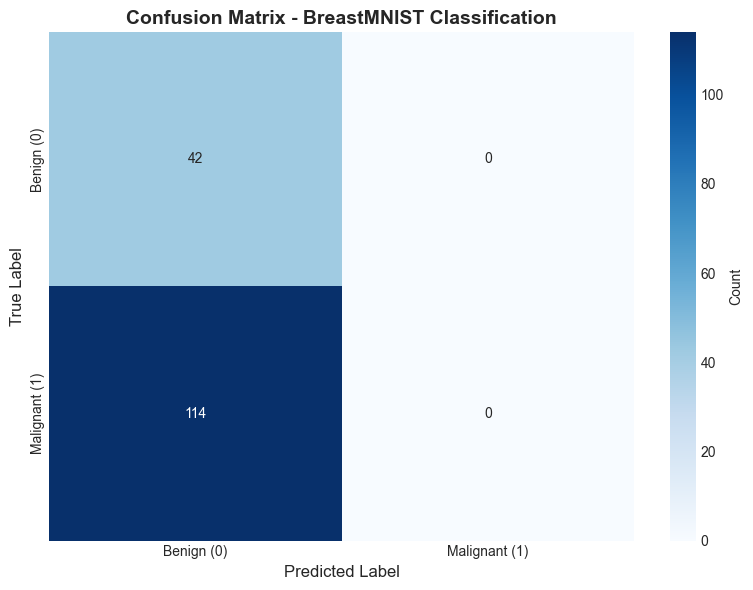


Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.27      1.00      0.42        42
Malignant (1)       0.00      0.00      0.00       114

     accuracy                           0.27       156
    macro avg       0.13      0.50      0.21       156
 weighted avg       0.07      0.27      0.11       156



/Users/louisewiljander/Documents/Projects/fl-lab/FedCAD/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/louisewiljander/Documents/Projects/fl-lab/FedCAD/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/louisewiljander/Documents/Projects/fl-lab/FedCAD/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

In [36]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign (0)', 'Malignant (1)'],
            yticklabels=['Benign (0)', 'Malignant (1)'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix - BreastMNIST Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, 
                          target_names=['Benign (0)', 'Malignant (1)']))

### ROC Curve and AUC

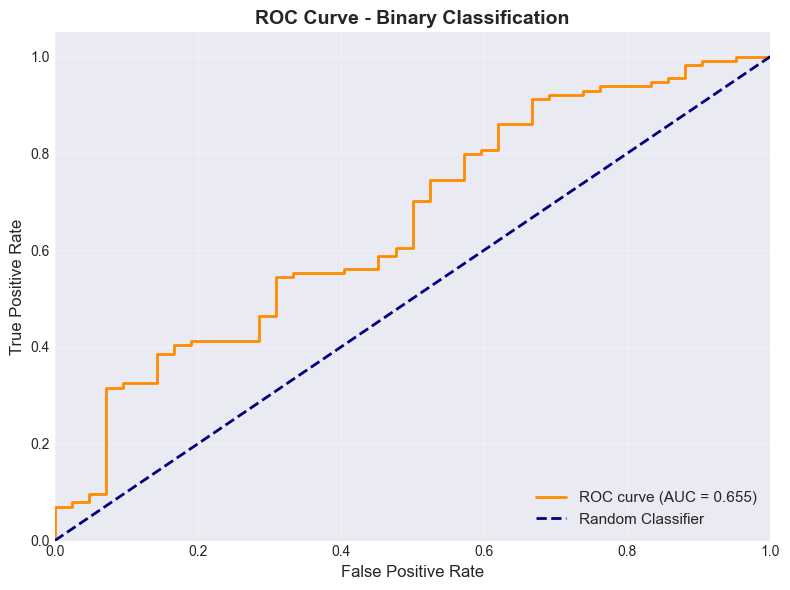

In [37]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Binary Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Precision-Recall Curve

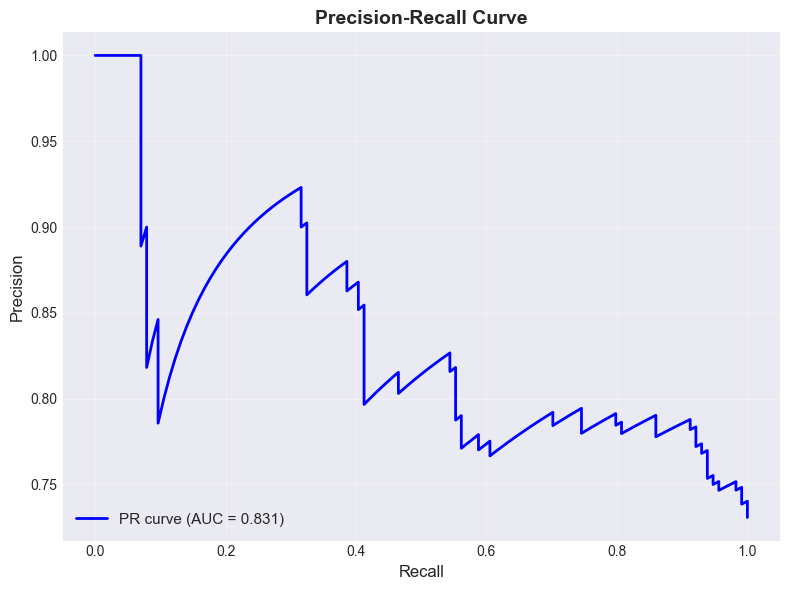

In [38]:
# Compute precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probabilities[:, 1])
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Prediction Examples

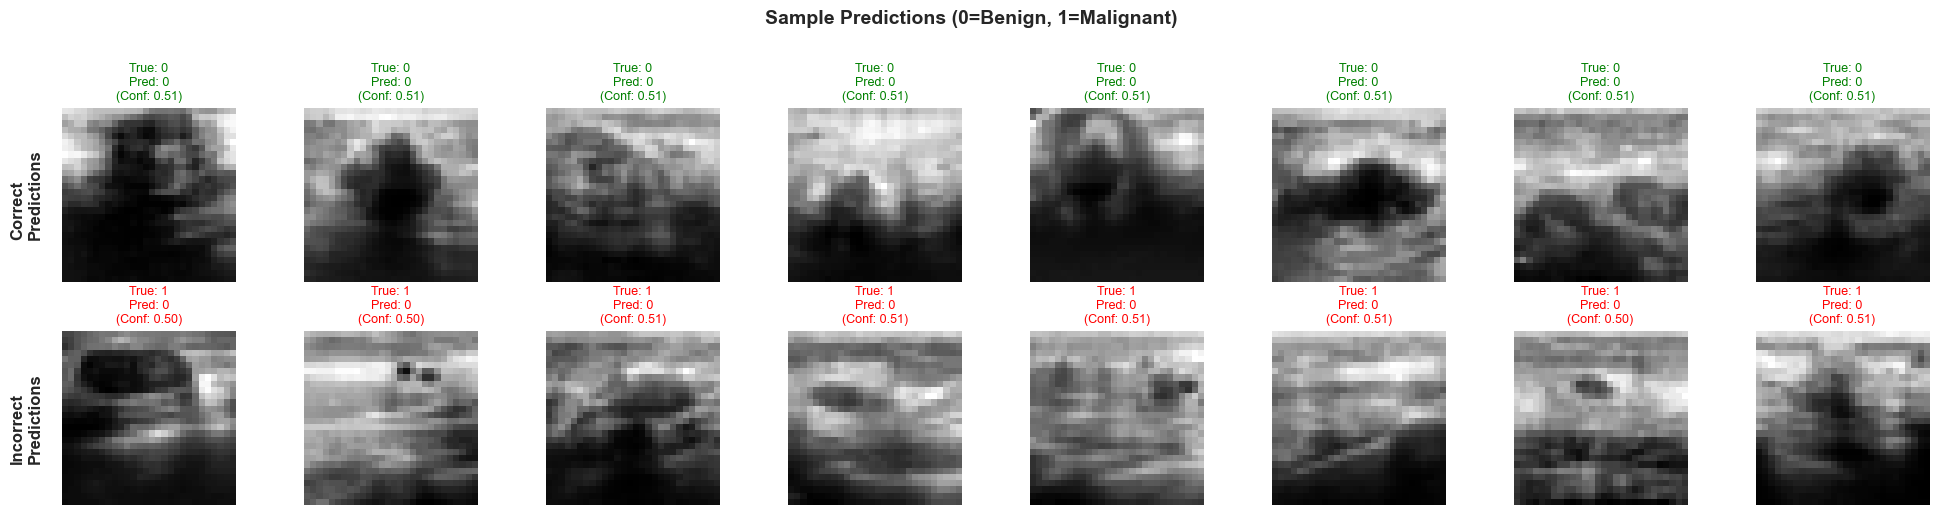


Total Correct: 42 / 156 (26.92%)
Total Incorrect: 114 / 156 (73.08%)


In [39]:
# Show correct and incorrect predictions
correct_mask = all_predictions == all_labels
incorrect_indices = np.where(~correct_mask)[0]
correct_indices = np.where(correct_mask)[0]

# Sample some examples
n_examples = 8
fig, axes = plt.subplots(2, n_examples, figsize=(20, 5))

# Show correct predictions
for i in range(min(n_examples, len(correct_indices))):
    idx = correct_indices[i]
    img = all_images[idx].squeeze()
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'True: {all_labels[idx]}\nPred: {all_predictions[idx]}\n(Conf: {all_probabilities[idx][all_predictions[idx]]:.2f})',
                        color='green', fontsize=9)

axes[0, 0].text(-0.3, 0.5, 'Correct\nPredictions', transform=axes[0, 0].transAxes,
               fontsize=12, fontweight='bold', va='center', rotation=90)

# Show incorrect predictions
for i in range(min(n_examples, len(incorrect_indices))):
    idx = incorrect_indices[i]
    img = all_images[idx].squeeze()
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'True: {all_labels[idx]}\nPred: {all_predictions[idx]}\n(Conf: {all_probabilities[idx][all_predictions[idx]]:.2f})',
                        color='red', fontsize=9)

if len(incorrect_indices) > 0:
    axes[1, 0].text(-0.3, 0.5, 'Incorrect\nPredictions', transform=axes[1, 0].transAxes,
                   fontsize=12, fontweight='bold', va='center', rotation=90)

plt.suptitle('Sample Predictions (0=Benign, 1=Malignant)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nTotal Correct: {np.sum(correct_mask)} / {len(all_labels)} ({100*np.sum(correct_mask)/len(all_labels):.2f}%)")
print(f"Total Incorrect: {len(incorrect_indices)} / {len(all_labels)} ({100*len(incorrect_indices)/len(all_labels):.2f}%)")

### Confidence Distribution

/var/folders/n4/4l9m_t6d49bg5p46d5j5tmzr0000gn/T/ipykernel_79133/2044964615.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([correct_confidences, incorrect_confidences],


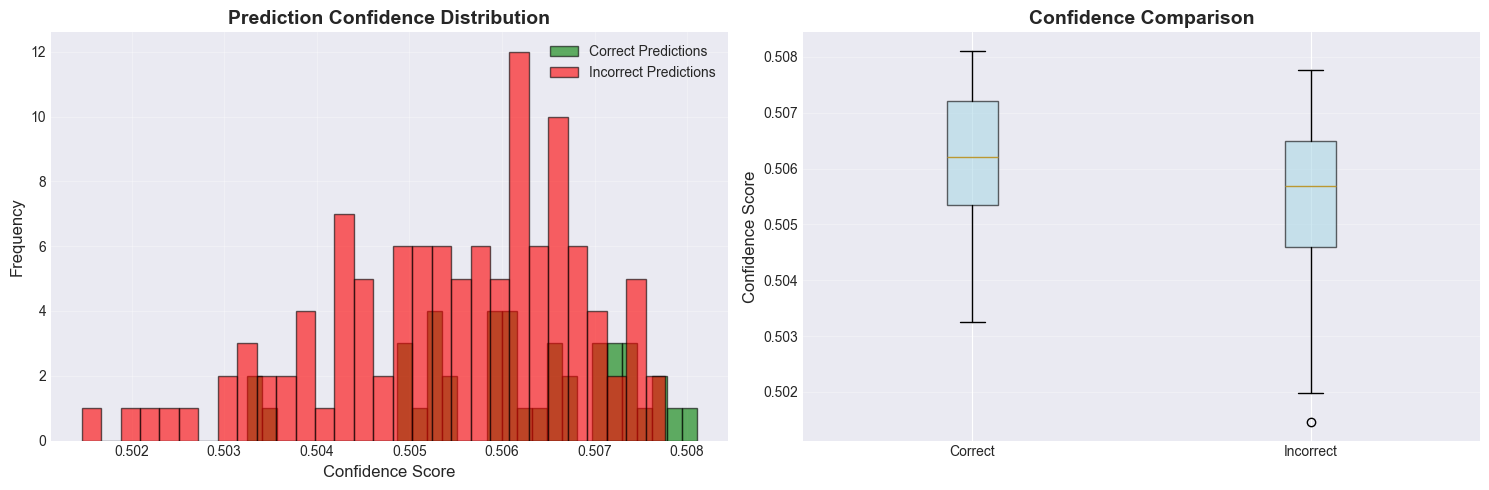


Average confidence for correct predictions: 0.506
Average confidence for incorrect predictions: 0.505


In [40]:
# Analyze prediction confidence
confidence_scores = np.max(all_probabilities, axis=1)
correct_confidences = confidence_scores[correct_mask]
incorrect_confidences = confidence_scores[~correct_mask]

# Plot confidence distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(correct_confidences, bins=30, alpha=0.6, label='Correct Predictions', color='green', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=30, alpha=0.6, label='Incorrect Predictions', color='red', edgecolor='black')
axes[0].set_xlabel('Confidence Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot([correct_confidences, incorrect_confidences], 
               labels=['Correct', 'Incorrect'],
               patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.6))
axes[1].set_ylabel('Confidence Score', fontsize=12)
axes[1].set_title('Confidence Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nAverage confidence for correct predictions: {np.mean(correct_confidences):.3f}")
print(f"Average confidence for incorrect predictions: {np.mean(incorrect_confidences):.3f}")

## 3. Class Distribution Analysis

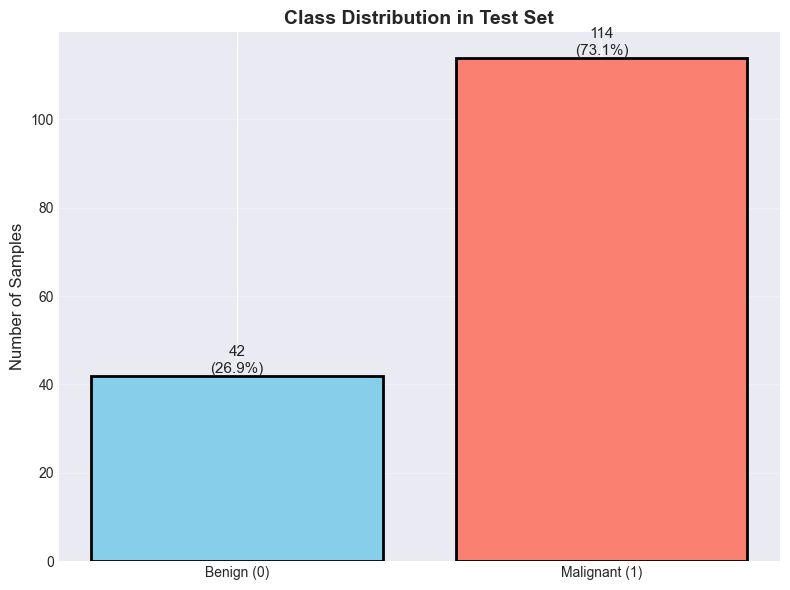


Class 0 (Benign): 42 samples (26.92%)
Class 1 (Malignant): 114 samples (73.08%)


In [41]:
# Class distribution in test set
class_counts = np.bincount(all_labels)

plt.figure(figsize=(8, 6))
bars = plt.bar(['Benign (0)', 'Malignant (1)'], class_counts, 
              color=['skyblue', 'salmon'], edgecolor='black', linewidth=2)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in Test Set', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({100*height/len(all_labels):.1f}%)',
            ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\nClass 0 (Benign): {class_counts[0]} samples ({100*class_counts[0]/len(all_labels):.2f}%)")
print(f"Class 1 (Malignant): {class_counts[1]} samples ({100*class_counts[1]/len(all_labels):.2f}%)")